Consider the model:

$Y = aX + bU + e2$

$X = cV + dU + e1$

where $U, V, X, Y$ are all one dimensional r.v.s. $V$ is the instrumental variable.



In [7]:
# IV model data generation
IV.model.generate <- function(a = 1, b = 1, d = 1, k = 2, samplesize = 1000) {
  #  Y = aX + bU + e2
  #  X = cV + dU + e1
    cc <- matrix(1/sqrt(k), k, 1)
  U <- rnorm(samplesize, 0, 1)
  V <- matrix(rnorm(samplesize * k, 0, 1), samplesize, k)
  e1 <- rnorm(samplesize, 0, .1)
  e2 <- rnorm(samplesize, 0, .1)
  X <-  V %*% cc + d * U + e1
  Y <- a * X + b * U + e2
  return(list(X = X, Y = Y, V = V, U = U, e1 = e1, e2 = e2, k = k, samplesize=samplesize))
}

GMM estimation is as the following

1. Given a estimated $W$ of 
$$
\Omega \gets \left(
\mathbb{E} (Y - aX)^2V\cdot V'
\right)
$$
2. let $\hat G$ and $\hat v$ be 
$$
\hat G \gets \left(
- \overline{XV}
\right),
\hat v \gets \left(
\overline{YV}
\right)
$$
and estimate $\tilde \beta$ by 
$$
\tilde \beta \gets (\hat G' W \hat G)^{-1} (\hat G' W \hat v)
$$
3. Then define $\tilde \Omega$ to be
$$
\tilde \Omega \gets \left(\overline{(Y - \tilde \beta X)^2V\cdot V'}
\right)
$$
and get the final estimate $\hat \beta$ 
$$
\hat \beta \gets (\hat G' \tilde \Omega \hat G)^{-1} (\hat G' \tilde \Omega \hat v)$$


In [8]:
rep.col<-function(x,n){
   matrix(rep(x,each=n), ncol=n, byrow=TRUE)
}
homemade.gmm <- function(data, a0) {
    y <- data$Y
    x <- data$X
    v <- data$V
    k <- data$k
    n <- data$samplesize
    err <- rep.col(y - a0*x, k) * v
    W <- t(err) %*% (err) / n
    hatG <- t(v) %*% x / n
    #cat(dim(hatG))
    hatv <- t(v) %*% y / n
    tilde.a <- (t(hatG) %*% W %*% hatv)/(t(hatG) %*% W %*% hatG)
    #cat(' ', dim(tilde.a), ' ', dim(x), ' ')
    err <- rep.col(y - x %*% tilde.a, k) * v
    tilde.omega <- t(err) %*% (err) / n
    hat.a <- (t(hatG) %*% tilde.omega %*% hatv)/(t(hatG) %*% tilde.omega %*% hatG)
    return(hat.a) 
}

simulate a thousand times to get an estimate of the bias

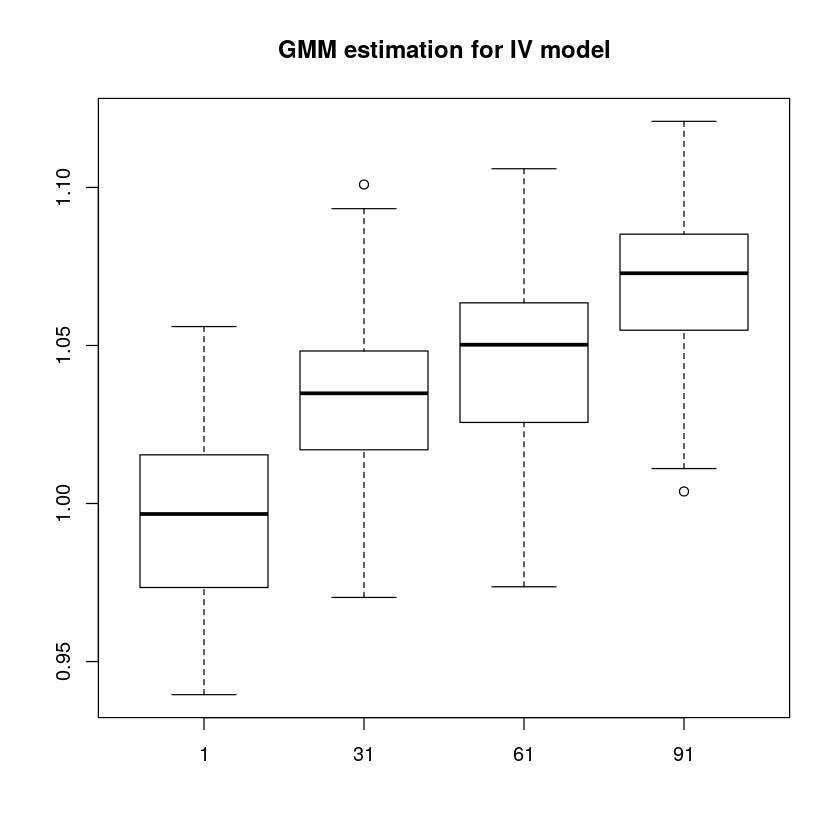

In [25]:
trials <- 30
ks <- seq(1, 100, by = 30)
hat.a <- matrix(NA, trials, length(ks))
samplesize <- 1000
for (j in 1:length(ks)) {
    k <- ks[j]
    for (i in 1:trials) {
        data <- IV.model.generate(samplesize = samplesize, k = k)
        hat.a[i, j] <- homemade.gmm(data, 1)
    }
}

boxplot(hat.a, names = ks)
title('GMM estimation for IV model')

Empirical likelihood estimation


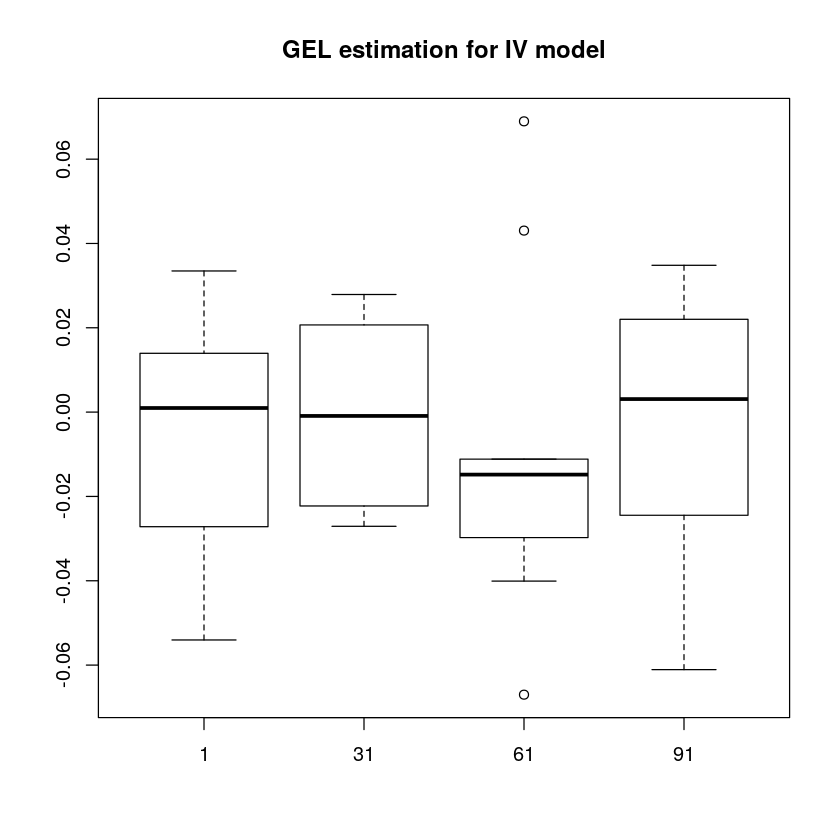

In [23]:
el <- function(data, a0) {
    y <- data$Y
    x <- data$X
    v <- data$V
    k <- data$k
    n <- data$samplesize
    require('gmm')
    g <- y ~ x
    res <- gel(g, v)
    #print(summary(res))
    return(res$coefficients[1])
}
trials <- 10
ks <- seq(1, 100, by = 30)
hat.a <- matrix(NA, trials, length(ks))
samplesize <- 1000
for (j in 1:length(ks)) {
    k <- ks[j]
    for (i in 1:trials) {
        data <- IV.model.generate(samplesize = samplesize, k = k)
        hat.a[i, j] <- el(data, 1)
    }
}

boxplot(hat.a, names = ks)
title('GEL estimation for IV model')

In [13]:
print(1)

[1] 1
